In [ ]:
import xarray as xr
import dask

In [ ]:
ds = xr.Dataset({"a": (("y", "x"), [[10, 20, 30]]*5)}).chunk({"y": 1})

In [ ]:
ds = dask.optimize(ds)[0]
ds.compute()

TypeError: string indices must be integers

In [ ]:
ds["a"] = dask.optimize(ds["a"])[0]
ds["a"].compute()

TypeError: string indices must be integers

In [ ]:
ds.a.data, = dask.optimize(ds.a.data)
ds.a.compute()

TypeError: string indices must be integers

In [ ]:
a = dask.array.ones((10,5), chunks=(1,3))
a = dask.optimize(a)[0]
a.compute()

array([[1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1.]])

In [ ]:
da = xr.DataArray(a)
da = dask.optimize(da)[0]
da.compute()

<xarray.DataArray 'ones-ab3504cdfe76d6e53da874eab504ccd8' (dim_0: 10, dim_1: 5)>
array([[1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1.]])
Dimensions without coordinates: dim_0, dim_1

In [ ]:
da = xr.DataArray(a).chunk({"dim_0": 5})
da = dask.optimize(da)[0]
da.compute()

IndexError: tuple index out of range

In [ ]:
import xarray as xr
import sys; sys.path.append('../'); import pump
      
# roms = pump.model('../glade/tpos20/OUT/', kind='roms')

# roms

# Preprocess ROMS data

1. Interpolate all variables to cell centers
2. Get variable names in sync with MITgcm output.
3. Add depth = z_rho

In [ ]:
roms_dir = '../glade/tpos20/OUT/' 

zrho = xr.open_dataset(roms_dir + '/ocean_his_tpos20_1zrho.nc')
depth = zrho.z_rho.median(['eta_rho',
                            'xi_rho']).drop('ocean_time').squeeze().load()
zrho.close()

In [ ]:
roms_dir = '../glade/tpos20/OUT/' 

# surface = xr.open_dataset(roms_dir + '/obs_subset/surface_staggered.nc', decode_times=False)

def preprocess_roms(ds):
    zrho = xr.open_dataset(roms_dir + '/ocean_his_tpos20_1zrho.nc')
    depth = zrho.z_rho.drop('ocean_time').squeeze().load()
    zrho.close()

    ds = ds.rename({'ocean_time': 'time', 'temp': 'theta'})
    ds.time.attrs['units'] = 'seconds since 1957-01-01 00:00:00'
    ds.time.attrs['calendar'] = 'proleptic_gregorian'
    ds = xr.decode_cf(ds)

    dsnew = ds[['u', 'v', 'theta']]
    dsnew['depth'] = depth

    for vv in ['u', 'v', 'rho']:
        dsnew['eta_' + vv] = dsnew['lat_' + vv].isel({'xi_' + vv: 0}).values
        dsnew['xi_' + vv] = dsnew['lon_' + vv].isel({'eta_' + vv: 0}).values
        dsnew = (dsnew.drop(['lat_' + vv, 'lon_' + vv]).rename({
            'eta_' + vv:
            'lat_' + vv,
            'xi_' + vv:
            'lon_' + vv
        }))

    for vv in ['u', 'v']:
        dsnew[vv] = (dsnew[vv]
                     .interp({'lat_' + vv: dsnew.lat_rho.values,
                              'lon_' + vv: dsnew.lon_rho.values})
                     .rename({'lat_' + vv: 'lat_rho',
                              'lon_' + vv: 'lon_rho'}))
    
    # dsnew['s_rho'] = depth

    return (dsnew
            .drop(['lat_u', 'lat_v', 'lon_u', 'lon_v'])
            .rename({'lon_rho': 'longitude',
                     'lat_rho': 'latitude'}))

## time-mean

In [ ]:
roms_full = xr.open_dataset('../glade/tpos20/OUT/proc/ocean_avg_all_yearmean.nc', decode_times=False)
roms_mean = preprocess_roms(roms_full)
roms_mean = roms_mean.set_coords(['depth'])

In [ ]:
roms_mean.sel(latitude=0, longitude=-140, method='nearest').u.plot(x='time', y='depth')

In [ ]:
roms_mean.isel(time=1).to_netcdf(roms_dir + '/obs_subset/time-mean.nc')

section_lons = [-95, -110, -125, -140, -155, -170]

(roms_mean.isel(time=1)
 .sel(longitude=section_lons, method='nearest')
 .to_netcdf(roms_dir + '/obs_subset/johnson-section-mean.nc'))

In [ ]:
# %time surface2 = preprocess_roms(surface)
%time surface2.squeeze().to_netcdf(roms_dir + '/obs_subset/surface.nc')

Exception ignored in: <object repr() failed>
Traceback (most recent call last):
  File "/gpfs/u/home/dcherian/python/xarray/xarray/backends/file_manager.py", line 204, in __del__
    ref_count = self._ref_counter.decrement(self._key)
AttributeError: 'CachingFileManager' object has no attribute '_ref_counter'


NameError: name 'FILE_CACHE' is not defined

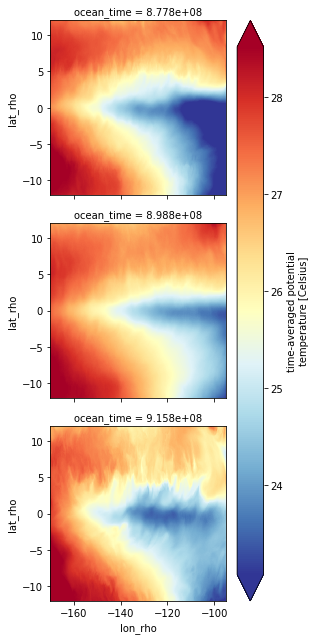

In [ ]:
import matplotlib as mpl

roms.temp.isel(s_rho=-1).plot(row='ocean_time', robust=True, cmap=mpl.cm.RdYlBu_r)

## extract TAO

In [ ]:
tao = pump.read_tao(roms.domain['xyt'])

In [ ]:
%time tao.to_netcdf(roms.dirname + '/obs_subset/tao-extract.nc')

/glade/u/home/dcherian/miniconda3/envs/dcpy/lib/python3.6/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in less
  return func(*args2)


CPU times: user 40.4 s, sys: 46.1 s, total: 1min 26s
Wall time: 46.4 s
